# Case 2: Collaborative Filtering via Deep Learning
-----

In this case, there are two main tasks:

- First, you need to build a deep learning model to predict the movie ratings.

- Then you will analyze the predicted ratings and provide an estimate of the movie valuation.


## Instructions

You need to fill in the missing code and submit the following files on Canvas
site:

1. A report in the pdf format containing the plots and the answers to the questions stated in the provided Jupyter notebook (Please read carefully the notebook and make sure answer every question);

2. The complete Jupyter notebook containing all your PyTorch code with explanations, along with
a Markdown text explaining different parts if needed.


## Introduction
One very common problem to solve is when you have a number of users and a number of products, and you want to recommend which products are most likely to be useful for which users. There are many variations of this: for example, recommending movies (such as on Netflix), figuring out what to highlight for a user on a home page, deciding what stories to show in a social media feed, and so forth. There is a general solution to this problem, called *collaborative filtering*, which works like this: look at what products the current user has used or liked, find other users that have used or liked similar products, and then recommend other products that those users have used or liked.

For example, on Netflix you may have watched lots of movies that are science fiction, full of action, and were made in the 1970s. Netflix may not know these particular properties of the films you have watched, but it will be able to see that other people that have watched the same movies that you watched also tended to watch other movies that are science fiction, full of action, and were made in the 1970s. In other words, to use this approach we don't necessarily need to know anything about the movies, except who like to watch them.

There is actually a more general class of problems that this approach can solve, not necessarily involving users and products. Indeed, for collaborative filtering we more commonly refer to *items*, rather than *products*. Items could be links that people click on, diagnoses that are selected for patients, and so forth.

The key foundational idea is that of *latent factors*. In the Netflix example, we started with the assumption that you like old, action-packed sci-fi movies. But you never actually told Netflix that you like these kinds of movies. And Netflix never actually needed to add columns to its movies table saying which movies are of these types. Still, there must be some underlying concept of sci-fi, action, and movie age, and these concepts must be relevant for at least some people's movie watching decisions.



---
In this case, we'll build an explicit feedback recommender system: that is, a model that takes into account explicit feedback signals (like ratings) to recommend new content. We'll use an approach first made popular by the [Netflix prize](https://en.wikipedia.org/wiki/Netflix_Prize) contest: [matrix factorization](https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf).

The basic idea is very simple:

1. Start with user-item-rating triplets, conveying the information that user _i_ gave some item _j_ rating _r_.
2. Represent both users and items as high-dimensional vectors of numbers. For example, a user could be represented by `[0.3, -1.2, 0.5]` and an item by `[1.0, -0.3, -0.6]`.
3. The representations should be chosen so that, when we multiplied together (via [dot products](https://en.wikipedia.org/wiki/Dot_product)), we can recover the original ratings.
4. The utility of the model then is derived from the fact that if we multiply the user vector of a user with the item vector of some item they _have not_ rated, we hope to obtain a predicition for the rating they would have given to it had they seen it.

<img src='https://storage.googleapis.com/gweb-cloudblog-publish/images/f1-collab_filtering.max-900x900.png?raw=true' width=50% />

We do not have access to Netflix's entire dataset of movie watching history, but there is a great dataset that we can use, called [MovieLens](https://grouplens.org/datasets/movielens/). This dataset contains tens of millions of movie rankings (a combination of a movie ID, a user ID, and a numeric rating).

We start with importing the [Movielens 1M dataset](https://grouplens.org/datasets/movielens/1M/).  It contains 1,000,209 anonymous ratings of approximately 3,706 movies made by 6,040 MovieLens users who joined MovieLens in 2000.

## Preparations

We first import the packages and download the data.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import imp
import numpy as np

from zipfile import ZipFile
try:
    from urllib.request import urlretrieve
except ImportError:  # Python 2 compat
    from urllib import urlretrieve

# this line need to be changed if not on colab:
data_folder = '/content/'


ML_1M_URL = "http://files.grouplens.org/datasets/movielens/ml-1m.zip"
ML_1M_FILENAME = op.join(data_folder,ML_1M_URL.rsplit('/', 1)[1])
ML_1M_FOLDER = op.join(data_folder,'ml-1m')

In [2]:
if not op.exists(ML_1M_FILENAME):
    print('Downloading %s to %s...' % (ML_1M_URL, ML_1M_FILENAME))
    urlretrieve(ML_1M_URL, ML_1M_FILENAME)

if not op.exists(ML_1M_FOLDER):
    print('Extracting %s to %s...' % (ML_1M_FILENAME, ML_1M_FOLDER))
    ZipFile(ML_1M_FILENAME).extractall(data_folder)

Extracting /content/ml-1m.zip to /content/ml-1m...


There are four different files:

- README
- movies.dat
- ratings.dat
- users.dat

You may read README to get the description of each dat files.

## Data analysis and formating

We start by loading the data with [Python Data Analysis Library](http://pandas.pydata.org/)

Note that the columns are separated by :: in the data.

In [3]:
import pandas as pd
all_ratings = pd.read_csv(op.join(ML_1M_FOLDER, 'ratings.dat'), sep='::',
                          names=["user_id", "item_id", "ratings", "timestamp"],engine='python')
all_ratings.head()

,user_id,item_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


When showing the data, we would rather see movie titles than their IDs. The `movies.dat` contains the correspondence of IDs to movie titles.

In [4]:
list_movies_names = []
list_item_ids = []
with open(op.join(ML_1M_FOLDER, 'movies.dat'), encoding = "ISO-8859-1") as fp:
    for line in fp:
        list_item_ids.append(line.split('::')[0])
        list_movies_names.append(line.split('::')[1])

movies_names = pd.DataFrame(list(zip(list_item_ids, list_movies_names)),
               columns =['item_id', 'item_name'])
movies_names.head()

,item_id,item_name
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


Here we add the title of the movies to the `all_ratings` data.

In [5]:
movies_names['item_id']=movies_names['item_id'].astype(int)
all_ratings['item_id']=all_ratings['item_id'].astype(int)
all_ratings = all_ratings.merge(movies_names,on='item_id')

In [6]:
all_ratings.head()

,user_id,item_id,ratings,timestamp,item_name
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975)
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975)
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975)
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975)
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975)


The dataframe `all_ratings` contains all the raw data for our problem.

In [7]:
#number of entries
len(all_ratings)

1000209

In [8]:
# statistics of ratings
all_ratings['ratings'].describe()

count    1.000209e+06
mean     3.581564e+00
std      1.117102e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: ratings, dtype: float64

In [9]:
# The ratings are 1, 2, 3, 4, 5
all_ratings['ratings'].unique()

array([5, 4, 3, 2, 1])

We now check the user IDs.

In [10]:
all_ratings['user_id'].describe()

count    1.000209e+06
mean     3.024512e+03
std      1.728413e+03
min      1.000000e+00
25%      1.506000e+03
50%      3.070000e+03
75%      4.476000e+03
max      6.040000e+03
Name: user_id, dtype: float64

In [11]:
# number of unique users
total_user_id = len(all_ratings['user_id'].unique())
print(total_user_id)

6040


We see that  the users seem to be indexed from 1 to 6040. Let's check that below using the following code.

In [12]:
list_user_id = list(all_ratings['user_id'].unique())
list_user_id.sort()

In [13]:
for i,j in enumerate(list_user_id):
    if j != i+1:
        print(i,j)

We can see that `list_user_id` contains contiguous indices from 1 to 6040.

We create a new column `user_num` to get an index from 0 to 6039 for users:

In [14]:
all_ratings['user_num'] = all_ratings['user_id'].apply(lambda x :x-1)

In [15]:
all_ratings.head()

,user_id,item_id,ratings,timestamp,item_name,user_num
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),0
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),1
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),11
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),14
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),16


We now look at movies.

In [16]:
all_ratings['item_id'].describe()

count    1.000209e+06
mean     1.865540e+03
std      1.096041e+03
min      1.000000e+00
25%      1.030000e+03
50%      1.835000e+03
75%      2.770000e+03
max      3.952000e+03
Name: item_id, dtype: float64

In [17]:
# number of unique rated items
total_item_id = len(all_ratings['item_id'].unique())
print(total_item_id)

3706


Here there is a clear problem: there are 3706 different movies but the range of `item_id` starts at 1 and ends at 3952. So there are gaps, so the first thing you will need to do is to create a new column `item_num` so that all movies are indexed from 0 to 3705.

In [18]:
itemnum_2_itemid = list(all_ratings['item_id'].unique())
itemnum_2_itemid.sort()
itemid_2_itemnum = {c:i for i,c in enumerate(itemnum_2_itemid)}
all_ratings['item_num'] = all_ratings['item_id'].apply(lambda x: itemid_2_itemnum[x])

This function will verify that we have created `item_num` correctly.

In [19]:
def check_ratings_num(df):
    item_num = set(df['item_num'])
    if item_num == set(range(len(item_num))):
        return True
    else:
        return False

In [20]:
check_ratings_num(all_ratings)

True

In [21]:
all_ratings.head()

,user_id,item_id,ratings,timestamp,item_name,user_num,item_num
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),0,1104
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),1,1104
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),11,1104
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),14,1104
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),16,1104


### Preliminary data analysis

**Exercise**: Find the top 10 most popular movies in the dataset and include the result in your report.

In [34]:
all_ratings['item_name'].value_counts().nlargest(100)[50:100]

Casablanca (1942)                                                              1669
Die Hard (1988)                                                                1666
GoodFellas (1990)                                                              1657
Hunt for Red October, The (1990)                                               1652
Speed (1994)                                                                   1650
Indiana Jones and the Last Crusade (1989)                                      1628
Lethal Weapon (1987)                                                           1627
Monty Python and the Holy Grail (1974)                                         1599
Toy Story 2 (1999)                                                             1585
When Harry Met Sally... (1989)                                                 1568
Good Will Hunting (1997)                                                       1548
Titanic (1997)                                                              

**Exercise**: Plot the histogram of popularity (x-axis: # of given ratings, y-axis: # of movies with the given # of ratings). Include the plot in your report.

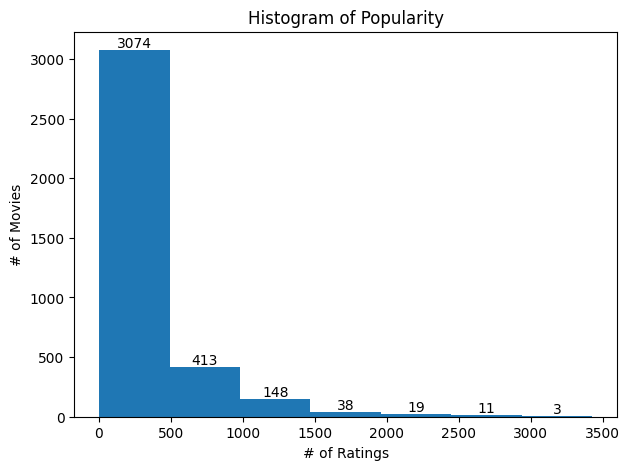

In [23]:
plt.figure(figsize=(7,5))
_, _, bars = plt.hist(all_ratings['item_name'].value_counts(), bins=7)
plt.bar_label(bars)
plt.title('Histogram of Popularity')
plt.xlabel('# of Ratings')
plt.ylabel('# of Movies')
plt.show()

**Exercise**: Plot the histogram of user activity (x-axis: # of given ratings, y-axis: # of users with the given # of ratings). Include the plot in your report.

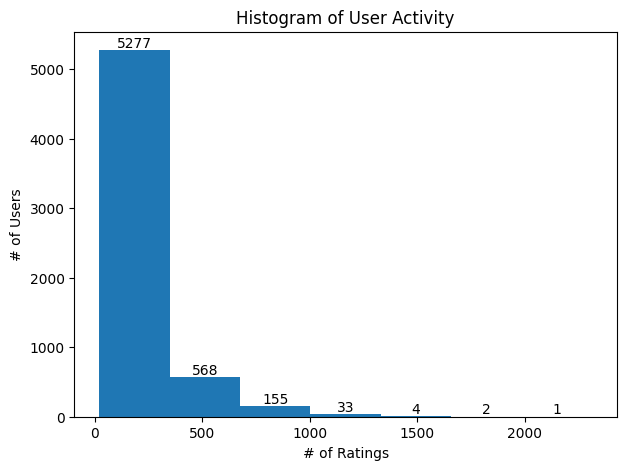

In [24]:
plt.figure(figsize=(7,5))
_, _, bars = plt.hist(all_ratings['user_num'].value_counts(), bins=7)
plt.bar_label(bars)
plt.title('Histogram of User Activity')
plt.xlabel('# of Ratings')
plt.ylabel('# of Users')
plt.show()

**Exercise**: Compute the average ratings for every movie and find the top 20 highly rated movies. Include the list of 20 highly rated movies and their ratings in your report.

In [25]:
average_ratings = all_ratings.groupby(["item_name"])["ratings"].mean()
average_ratings.nlargest(20)

item_name
Baby, The (1973)                                                       5.000000
Bittersweet Motel (2000)                                               5.000000
Follow the Bitch (1998)                                                5.000000
Gate of Heavenly Peace, The (1995)                                     5.000000
Lured (1947)                                                           5.000000
One Little Indian (1973)                                               5.000000
Schlafes Bruder (Brother of Sleep) (1995)                              5.000000
Smashing Time (1967)                                                   5.000000
Song of Freedom (1936)                                                 5.000000
Ulysses (Ulisse) (1954)                                                5.000000
I Am Cuba (Soy Cuba/Ya Kuba) (1964)                                    4.800000
Lamerica (1994)                                                        4.750000
Apple, The (Sib) (1998)       

We see that some highly rated movies are not popular ones.

---
## Train, Validation, and Test Data

Now we will split the data in _train_, _val_ and _test_ be using a pre-defined function from [scikit-learn](http://scikit-learn.org/stable/)

In [35]:
#Split the data into train, validation and test
from sklearn.model_selection import train_test_split

ratings_trainval, ratings_test = train_test_split(all_ratings, test_size=0.1, random_state=42)

ratings_train, ratings_val = train_test_split(ratings_trainval, test_size=0.1, random_state=42)

In [36]:
user_id_train = ratings_train['user_id']
item_id_train = ratings_train['item_id']
rating_train = ratings_train['ratings']

user_id_test = ratings_test['user_id']
item_id_test = ratings_test['item_id']
rating_test = ratings_test['ratings']

In [37]:
movies_not_train = list(set(all_ratings['item_id']) -set(item_id_train))
movies_not_train_name=set(all_ratings.loc[movies_not_train]['item_name'])
print(movies_not_train_name)

{'James and the Giant Peach (1996)', 'Erin Brockovich (2000)', "One Flew Over the Cuckoo's Nest (1975)", 'My Fair Lady (1964)'}


We see that a few movies are not rated in the train set. For those movies, it is hard to predict their ratings accurately.

---
## Data Load and Batching

Use GPU if available.

In [38]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

We define a function to return a triplet of user_num, item_num, rating from the dataframe.

In [39]:
def df_2_tensor(df, device):
    # return a triplet user_num, item_num, rating from the dataframe
    user_num = np.asarray(df['user_num'])
    item_num = np.asarray(df['item_num'])
    rating = np.asarray(df['ratings'])
    return torch.from_numpy(user_num).to(device), torch.from_numpy(item_num).to(device), torch.from_numpy(rating).to(device)

Below, we construct 3 tensors containing the `user_num`, `item_num` and `rating` for the training set. All tensors have the same shape so that `train_user_num[i]` watched `train_item_num[i]` and gave a rating of `train_rating[i]`.

In [40]:
train_user_num, train_item_num, train_rating = df_2_tensor(ratings_train,device)

We now do the same thing for the validation and test sets.

In [41]:
val_user_num, val_item_num, val_rating = df_2_tensor(ratings_val,device)
test_user_num, test_item_num, test_rating = df_2_tensor(ratings_test,device)

Now you need to construct a dataset and a dataloader. For this, you can define a first function taking as arguments the tensors defined above and returning a list (Hint: you may use the [zip function](https://www.w3schools.com/python/ref_func_zip.asp)); then a second function taking as argument a dataset, the batchsize and a boolean for the shuffling.

**Exercise**: Filling in the missing code below to construct dataset and dataloader.

In [42]:
def tensor_2_dataset(user,item,rating):
    # your code here
    # Hint: check the zip function
    return list(zip(user,item,rating))

def make_dataloader(dataset,bs,shuffle):
    # your code here
    return torch.utils.data.DataLoader(dataset,batch_size=bs,shuffle=shuffle)

In [43]:
train_dataset = tensor_2_dataset(train_user_num,train_item_num, train_rating)
val_dataset = tensor_2_dataset(val_user_num,val_item_num,val_rating)
test_dataset = tensor_2_dataset(test_user_num, test_item_num, test_rating)

Load the train, validation, and test data in batchs of size 1024.

In [44]:
train_dataloader = make_dataloader(train_dataset,1024,True)
val_dataloader = make_dataloader(val_dataset,1024, False)
test_dataloader = make_dataloader(test_dataset,1024,False)

---
## The model



In [45]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

We will use some custom embeddings defined as below.

In [46]:
class ScaledEmbedding(nn.Embedding):
    """
    Embedding layer that initialises its values
    to using a normal variable scaled by the inverse
    of the embedding dimension.
    """
    def reset_parameters(self):
        """
        Initialize parameters.
        """

        self.weight.data.normal_(0, 1.0 / self.embedding_dim)
        if self.padding_idx is not None:
            self.weight.data[self.padding_idx].fill_(0.0)


class ZeroEmbedding(nn.Embedding):
    """
    Used for biases.
    """

    def reset_parameters(self):
        """
        Initialize parameters.
        """

        self.weight.data.zero_()
        if self.padding_idx is not None:
            self.weight.data[self.padding_idx].fill_(0.0)

### Creating Our Own Embedding Module

Now, we define the `Model_dot`(class to represents users and items. It's composed of a 4 `embedding` layers:

- a `(num_users x latent_dim)` embedding layer to represent users,
- a `(num_items x latent_dim)` embedding layer to represent items,
- a `(num_users x 1)` embedding layer to represent user biases, and
- a `(num_items x 1)` embedding layer to represent item biases.







**Exercise**: Fill the missing code to define the embeddings.

In [47]:
class DotModel(nn.Module):

    def __init__(self,
                 num_users,
                 num_items,
                 embedding_dim=32):

        super(DotModel, self).__init__()

        self.embedding_dim = embedding_dim

        # TODO: generate user and item embeddigns using ScaledEmbedding
        # your code
        self.user_embeddings = ScaledEmbedding(num_users, embedding_dim)
        self.item_embeddings = ScaledEmbedding(num_items, embedding_dim)

        # TODO: generate bias embeddigns using ZeroEmbedding
        # your code
        self.user_biases = ZeroEmbedding(num_users, 1)
        self.item_biases = ZeroEmbedding(num_items, 1)


    def forward(self, user_ids, item_ids):
        #
        # your code
        #
        user_embedding = self.user_embeddings(user_ids)
        item_embedding = self.item_embeddings(item_ids)

        user_bias = self.user_biases(user_ids).squeeze()
        item_bias = self.item_biases(item_ids).squeeze()

        dot = torch.mul(user_embedding, item_embedding).sum(1)
        res = dot + user_bias + item_bias

        return res

Note that in the above code, we use [`torch.mul`](https://pytorch.org/docs/stable/generated/torch.mul.html), which performs an elementwise multiplication with broadcasting.

In [48]:
net = DotModel(total_user_id,total_item_id).to(device)

In [49]:
net

DotModel(
  (user_embeddings): ScaledEmbedding(6040, 32)
  (item_embeddings): ScaledEmbedding(3706, 32)
  (user_biases): ZeroEmbedding(6040, 1)
  (item_biases): ZeroEmbedding(3706, 1)
)

Now we check your network by taking  a batch from train loader.

In [50]:
batch_user, batch_item, batch_rating = next(iter(train_dataloader))
batch_user, batch_item, batch_rating = batch_user.to(device), batch_item.to(device), batch_rating.to(device)

In [51]:
predictions = net(batch_user, batch_item)
predictions.shape

torch.Size([1024])

We will use MSE loss defined below:

In [52]:
def regression_loss(predicted_ratings, observed_ratings):
    return ((observed_ratings - predicted_ratings) ** 2).mean()

In [53]:
loss=regression_loss(predictions,batch_rating)

In [54]:
loss

tensor(13.8764, device='cuda:0', grad_fn=<MeanBackward0>)

## Train and test the model

Now we define `FactorizationModel` class  that allows us to train and evaluate the explicit factorization models.


- The `fit` function should take as argument a dataloader for the training and a dataloader for the validation. At the end of each epoch, you run the test method on the validation set. Then you print both the loss on the training set and on the validation set to see if you are overfitting.

- Weight decay, or *L2 regularization*, consists in adding to your loss function the sum of all the weights squared. Why do that? Because when we compute the gradients, it will add a contribution to them that will encourage the weights to be as small as possible.

**Exercise**: Filling in the missing code below to complete the training pass and validation pass.

In [55]:
class FactorizationModel(object):

    def __init__(self, embedding_dim=32, n_iter=10, l2=0.0,
                 learning_rate=1e-2, device=device, net=None, num_users=None,
                 num_items=None,random_state=None):

        self._embedding_dim = embedding_dim
        self._n_iter = n_iter
        self._learning_rate = learning_rate
        self._l2 = l2
        self._device = device
        self._num_users = num_users
        self._num_items = num_items
        self._net = net
        self._optimizer = None
        self._loss_func = None
        self._random_state = random_state or np.random.RandomState()


    def _initialize(self):
        if self._net is None:
            self._net = DotModel(self._num_users, self._num_items, self._embedding_dim).to(self._device)

        self._optimizer = optim.Adam(
                self._net.parameters(),
                lr=self._learning_rate,
                weight_decay=self._l2
            )

        self._loss_func = regression_loss

    @property
    def _initialized(self):
        return self._optimizer is not None


    def fit(self, dataloader, val_dataloader, verbose=True):
        if not self._initialized:
            self._initialize()

        valid_loss_min = np.Inf # track change in validation loss
        train_losses, valid_losses, valid_maes =[], [], []

        for epoch_num in range(self._n_iter):
            tot_train_loss = 0.0
            ###################
            # train the model #
            ###################
            #TODO: trainining loop:
            # your code
            self._net.train()
            for batch_user, batch_item, batch_rating in dataloader:

                bath_user=batch_user.to(device)
                batch_item=batch_item.to(device)
                batch_rating=batch_rating.to(device)

                #1. Compute the output
                predictions = self._net(batch_user,batch_item)
                #2. Compute the loss
                #loss = self._loss_func(predictions,batch_rating)
                loss = self._loss_func(predictions,batch_rating)
                # 3. Zero out the gradient
                self._optimizer.zero_grad()
                # 4. Backward pass, compute the new gradients
                loss.backward()
                # 5. Update the weights
                self._optimizer.step()

                tot_train_loss += loss.item()


            train_loss = tot_train_loss /len(dataloader)
            # Go to the validation loop
            valid_loss, valid_mae = self.test(val_dataloader)
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            valid_maes.append(valid_mae)

            if verbose:
                print('Epoch {}: loss_train {}, loss_val {}'.format(epoch_num, train_loss,valid_loss))

            if np.isnan(train_loss) or train_loss == 0.0:
                raise ValueError('Degenerate train loss: {}'.format(train_loss))

            #TODO: Saving model if validation loss has decreased
            if valid_loss <= valid_loss_min:
              print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
              torch.save(self._net.state_dict(), 'model_cf.pt')
              valid_loss_min = valid_loss

        return train_losses, valid_losses, valid_maes


    ######################
    # validate/Test the model #
    ######################
    def test(self,dataloader, verbose = False):
        self._net.eval()
        L1loss = torch.nn.L1Loss()
        tot_test_loss = 0.0
        tot_test_mae = 0.0

        # TODO: validation/testing loop
        # your code here (mae = mean absolute error)
        with torch.no_grad():
          for batch_user, batch_item, batch_rating in dataloader:
            #1. compute the output
            predictions = self._net(batch_user,batch_item)
            #2. Compute the loss
            loss = self._loss_func(predictions,batch_rating)

            tot_test_loss += loss.item()
            tot_test_mae += L1loss(predictions,batch_rating.type(torch.FloatTensor).to(device))


        test_loss = tot_test_loss / len(dataloader)
        test_mae = tot_test_mae / len(dataloader)
        if verbose:
            print(f"RMSE: {np.sqrt(test_loss)}, MAE: {test_mae}")
        return test_loss, test_mae

In [56]:
model = FactorizationModel(embedding_dim=50,  # latent dimensionality
                                   n_iter=40,  # number of epochs of training
                                   learning_rate=5e-4,
                                   l2=1e-8,  # strength of L2 regularization
                                   num_users=total_user_id,
                                   num_items=total_item_id)

In [57]:
train_losses,valid_losses,valid_maes =model.fit(train_dataloader,val_dataloader)

Epoch 0: loss_train 10.362784383874951, loss_val 3.480921130288731
Validation loss decreased (inf --> 3.480921).  Saving model ...
Epoch 1: loss_train 1.7366186863545217, loss_val 1.1323646171526476
Validation loss decreased (3.480921 --> 1.132365).  Saving model ...
Epoch 2: loss_train 0.9824582381230412, loss_val 0.913088402964852
Validation loss decreased (1.132365 --> 0.913088).  Saving model ...
Epoch 3: loss_train 0.8671033900946078, loss_val 0.856828626583923
Validation loss decreased (0.913088 --> 0.856829).  Saving model ...
Epoch 4: loss_train 0.8311822190128192, loss_val 0.8352504887364127
Validation loss decreased (0.856829 --> 0.835250).  Saving model ...
Epoch 5: loss_train 0.8127083071705067, loss_val 0.8222677186131477
Validation loss decreased (0.835250 --> 0.822268).  Saving model ...
Epoch 6: loss_train 0.7992973191419033, loss_val 0.811245355416428
Validation loss decreased (0.822268 --> 0.811245).  Saving model ...
Epoch 7: loss_train 0.7877153243982431, loss_val 0

**Exercise**: Let's plot the train losses and test losses over epoches.
At which epoch, you would stop the training? Include the plot and your answer in the report.

In [58]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

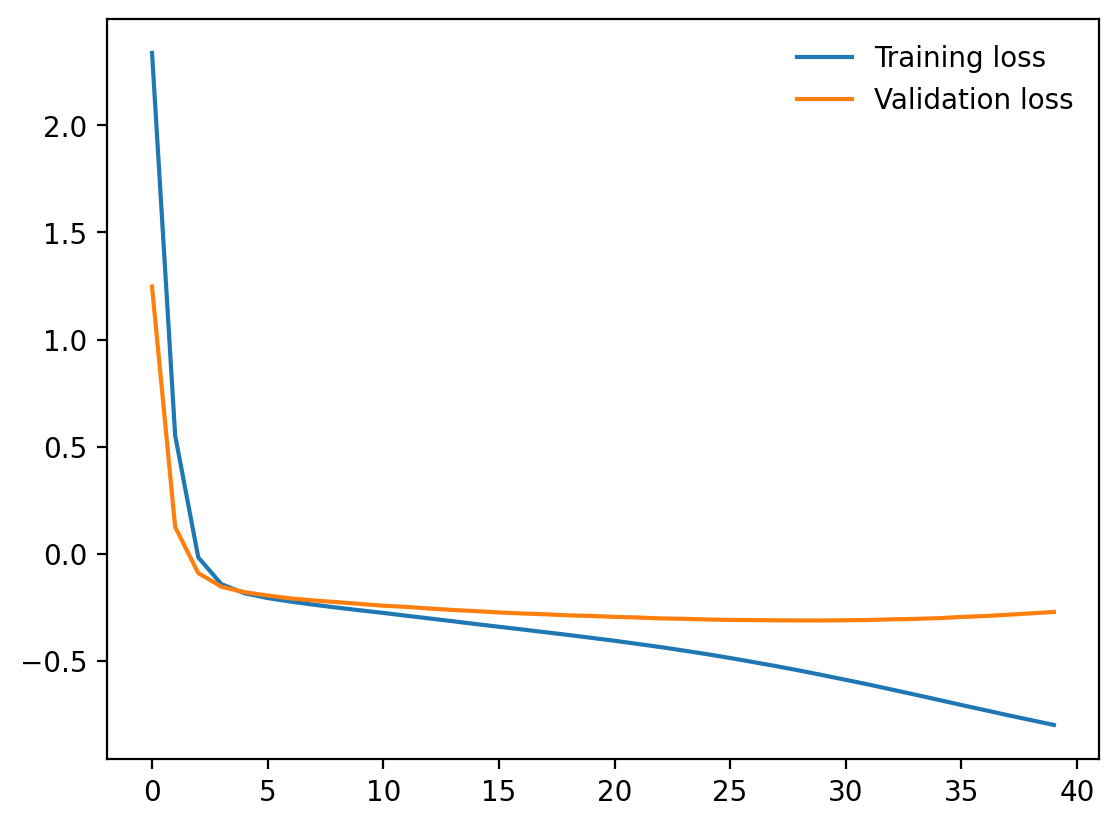

In [59]:
plt.plot(np.log(train_losses), label='Training loss')
plt.plot(np.log(valid_losses), label='Validation loss')
plt.legend(frameon=False)

We see that around epoch 30, we achieve the lowest validation loss and hence we would stop training at epoch 28.

Now, let's compute the RMSE and mean absolute error on the test data.

In [60]:
model._net.load_state_dict(torch.load('model_cf.pt'))

<All keys matched successfully>

In [61]:
test_loss, test_mae = model.test(test_dataloader,True)

RMSE: 0.8531858694121952, MAE: 0.6685224175453186


We see that our RMSE is around 0.85 and MAE is 0.67

## Optimize your model and training

**Exercise**: Play with the hyperparameters (embedding_dim, n_iter, learning_rate, L2 regularization, etc) to beat the benchmarks presented in [Surprise](https://github.com/NicolasHug/Surprise). List the hyperparameters and the RMSE and MAE on test data in the report. Save the model state to `model_cf.pt` and submit it to Canvas.


In [62]:
model_tuning = FactorizationModel(embedding_dim=128, # embedding_dim 50 --> 128
                  n_iter=20,
                  learning_rate=5e-4,
                  l2=5e-8,  # l2-penalty 1e-8 --> 5e-8
                  num_users=total_user_id,
                  num_items=total_item_id)
train_losses,test_losses, test_maes = model_tuning.fit(train_dataloader,val_dataloader)

Epoch 0: loss_train 6.892577576667372, loss_val 1.3667367642576045
Validation loss decreased (inf --> 1.366737).  Saving model ...
Epoch 1: loss_train 1.036278947585761, loss_val 0.906395205042579
Validation loss decreased (1.366737 --> 0.906395).  Saving model ...
Epoch 2: loss_train 0.8664639486808969, loss_val 0.8563498163765128
Validation loss decreased (0.906395 --> 0.856350).  Saving model ...
Epoch 3: loss_train 0.8402432093415597, loss_val 0.8445628861134703
Validation loss decreased (0.856350 --> 0.844563).  Saving model ...
Epoch 4: loss_train 0.8293256680622245, loss_val 0.8356798020276156
Validation loss decreased (0.844563 --> 0.835680).  Saving model ...
Epoch 5: loss_train 0.8187342726371505, loss_val 0.8276512622833252
Validation loss decreased (0.835680 --> 0.827651).  Saving model ...
Epoch 6: loss_train 0.8068242637497006, loss_val 0.8165447915142233
Validation loss decreased (0.827651 --> 0.816545).  Saving model ...
Epoch 7: loss_train 0.7938293477501532, loss_val 

In [243]:
model_tuning._net.load_state_dict(torch.load('model_cf_tuned.pt'))
test_loss, test_mae = model_tuning.test(test_dataloader,verbose=True)

RMSE: 0.8504484213801043, MAE: 0.6670928597450256


Here is comparison between the best benckmarks in [Surprise](https://github.com/NicolasHug/Surprise) and our model after hyperparameters tunning.

| [Movielens 1M](https://grouplens.org/datasets/movielens/1m)                                                                             |   RMSE |   MAE |
|:----------------------------------------------------------------------------------------------------------------------------------------|-------:|------:|
| [SVD++ (cache_ratings=False)](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVDpp)  |  0.862 | 0.672 |
| [SVD++ (cache_ratings=True)](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVDpp)  |  0.862 | 0.672 |
| **Ours**|  **0.850** | **0.666** |


Our model beats their best ones！

## Well Done!

<img src="https://video.udacity-data.com/topher/2018/November/5be21b06_dancing-beemo/dancing-beemo.gif?raw=true" width=40%>

## Interpreting Biases

Now you need to rank the movies according to their bias. For this, you need to recover the biases of the movies, make a list of the pairs `[name of the movie, its bias]` and then sort this list according to the biases. You can use the method sort of a list.

**Exercise**: What are your top 10 movies with the largest values of movie bias? What do you think about this ranking? Include your answers in your report.

In [244]:
#TODO: retreive the bias of the movies from your optimized model and store it in the numpy array item_bais_np
item_bias_np = model_tuning._net.item_biases.weight.data.cpu().numpy()
item_bias_np = item_bias_np.squeeze()

In [245]:
# construct a dictionary that maps item_num to item_name, and vice versa
numitem_2_name = {i:name for name,i in np.asarray(all_ratings[['item_name', 'item_num']])}
name_2_numitem = {name:i for name,i in np.asarray(all_ratings[['item_name', 'item_num']])}

In [246]:
# Construct a list of movie names and the corresponding bias.
list_name_bias = [[name, item_bias_np[name_2_numitem[name]]] for name in list(ratings_train['item_name'].unique())]

In [247]:
#TODO: sort the movie names by biases and output the top 10 movie names with the largest biases.
list_name_bias.sort(key= lambda x: x[1])
list_name_bias[-10:]

[["One Flew Over the Cuckoo's Nest (1975)", 0.34282196],
 ['Wrong Trousers, The (1993)', 0.3495579],
 ['Silence of the Lambs, The (1991)', 0.35871145],
 ['Usual Suspects, The (1995)', 0.36045986],
 ['Godfather, The (1972)', 0.36048493],
 ['Raiders of the Lost Ark (1981)', 0.3805813],
 ['Star Wars: Episode IV - A New Hope (1977)', 0.39394262],
 ["Schindler's List (1993)", 0.39718357],
 ['Shawshank Redemption, The (1994)', 0.39718616],
 ['Sixth Sense, The (1999)', 0.39723575]]

Think about what this means. What it's saying is that for each of these above movies, even when a user is NOT well matched to its latent factors (which, as we will see in a moment, tend to represent things like level of action, age of movie, and so forth), they still generally like it. We could have simply sorted the movies directly by their average rating, but looking at the learned bias tells us something much more interesting. It tells us not just whether a movie is of a kind that people tend to enjoy watching, but that people tend to like watching it even if it is not of a kind that they normally enjoy!

So, for instance, even if you don't normally enjoy horror thriller movies, you might enjoy *Silence of the Lambs*!


## PCA of movies' embeddings

Now you can also play with the embeddings learned by your algorithm for the movies.

It is not quite so easy to directly interpret the embedding matrices. There are just too many factors for a human to look at. But there is a technique that can pull out the most important underlying *directions* in such a matrix, called *principal component analysis* (PCA). We will not be going into this in detail in this class, because it is not particularly important for you to understand to be a deep learning practitioner. We can visualize the movie embeddings based on two of the strongest PCA components.

**Exercise**: Include the plot of the movie embeddings in your report. Do you observe anything interesting from the movie embeddings?

In [248]:
from sklearn.decomposition import PCA
from operator import itemgetter

In [249]:
#TODO: retrive your movie embedding vectors and store them as a numpy matrix
item_emb_np = model_tuning._net.item_embeddings.weight.data.cpu().numpy()

In [250]:
#Here we perform PCA to extract the 4 principal components
pca = PCA(n_components=4)
latent_fac = pca.fit_transform(item_emb_np)

Next, we plot the embeddings of the top 80 mostly rated movies using the second and third principal components.

In [251]:
#Here we get the top 1000 mostly rated movies
g = all_ratings.groupby('item_name')['ratings'].count()
most_rated_movies = g.sort_values(ascending=False).index.values[:1000]
# we get the corresponding movie numbers
most_rated_movies_num = [name_2_numitem[n] for n in most_rated_movies]

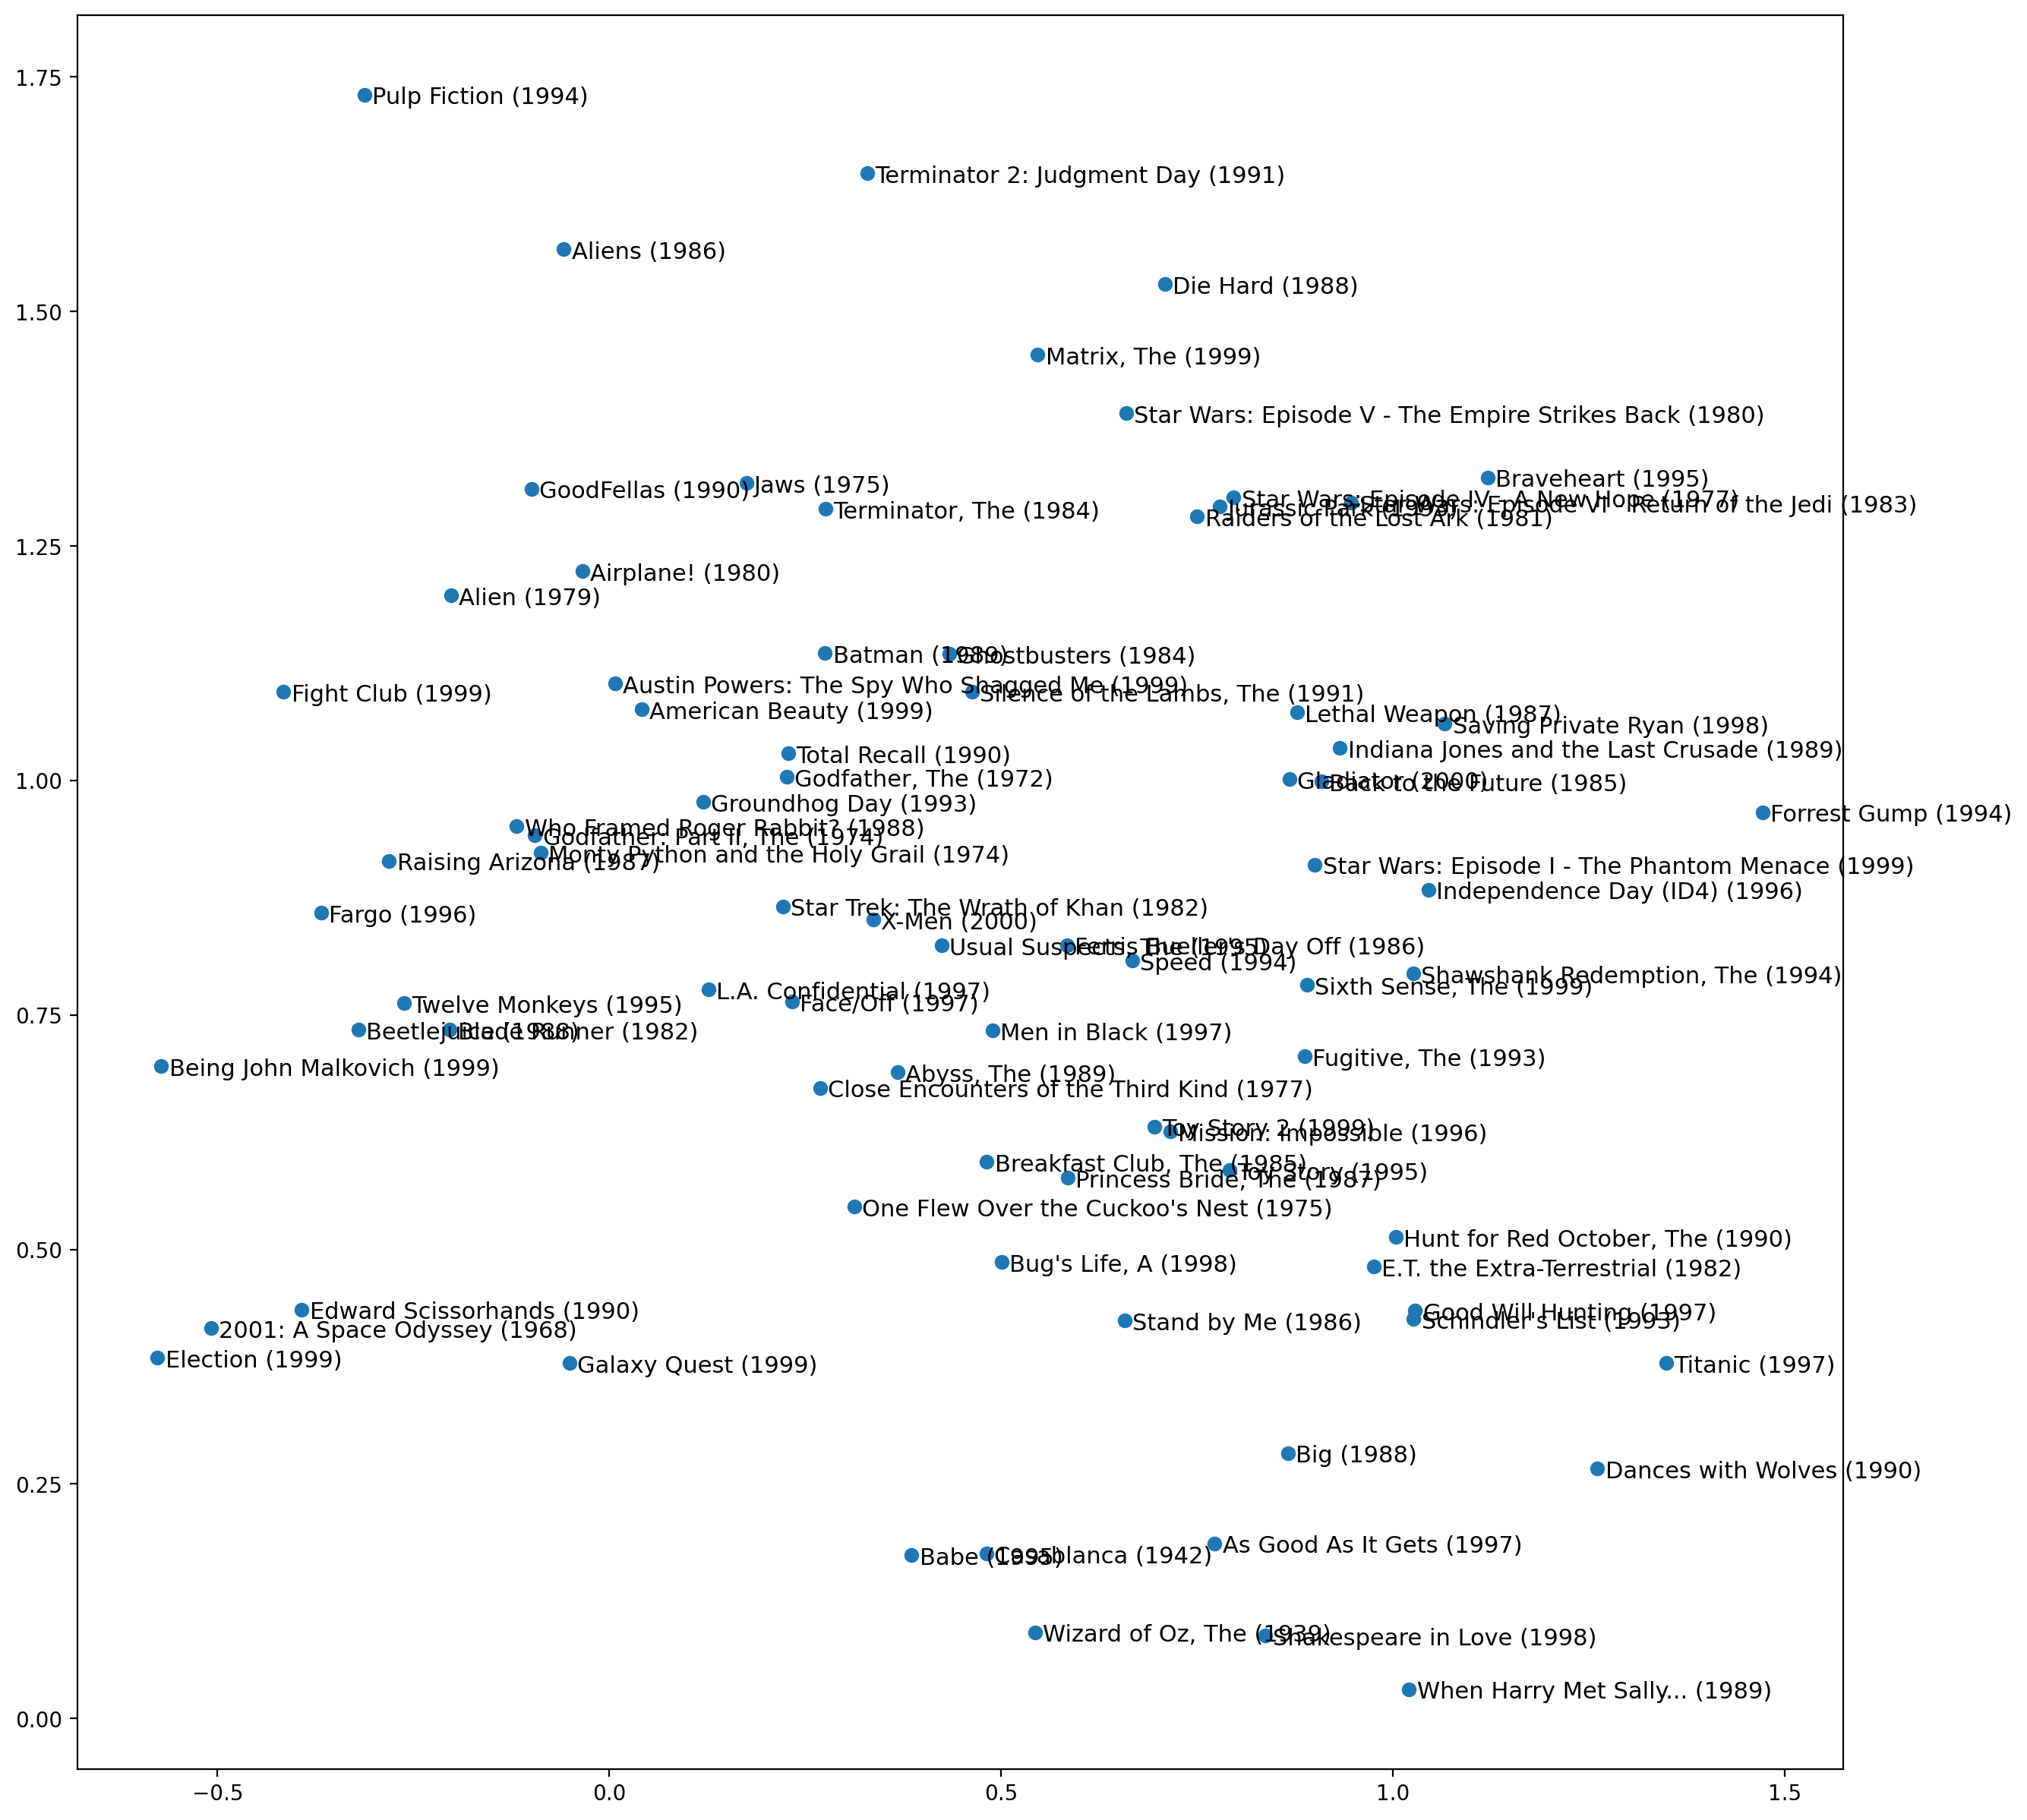

In [252]:
nums = most_rated_movies_num[:80]
txt_movies_names = [numitem_2_name[i] for i in nums]
X = latent_fac[nums,1]
Y = latent_fac[nums,2]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(txt_movies_names, X, Y):
    plt.text(x+0.01,y-0.01,i, fontsize=11)
plt.show()

We can see here that the model seems to have discovered a concept of action versus romance movies along y-axis.

## Predict your own ratings

Now that we have succesfully trained a model, let's see how to deal with the situation where we have a new user. How can we make recommendations to new users?

It turns out that we can utilize the learned movie embedding vectors to estimate new users' embedding vector, based on a few ratings from them. You may have noticed that when you sign up for services such as Pandora and Netflix, they tend to ask you a few questions about what movie or music you like; this is how they come up with your initial collaborative filtering recommendations.


- First, give 40 ratings between 1-5 to the movies that your team watched before among the mostly rated movies;

In [253]:
my_ratings = {'American Beauty (1999)' : 5,
        'Star Wars: Episode IV - A New Hope (1977)' : 2,
        'Star Wars: Episode V - The Empire Strikes Back (1980)' : 3,
        'Star Wars: Episode VI - Return of the Jedi (1983)' : 2,
        'Jurassic Park (1993)' : 4,
        'Saving Private Ryan (1998)' : 4,
        'Terminator 2: Judgment Day (1991)' : 3,
        'Matrix, The (1999)' : 4,
        'Back to the Future (1985)' : 5,
        'Silence of the Lambs, The (1991)' : 5,
        'Men in Black (1997)' : 3,
        'Raiders of the Lost Ark (1981)' : 2,
        'Fargo (1996)' : 3,
        'Sixth Sense, The (1999)' : 2,
        'Braveheart (1995)' : 5,
        'Shakespeare in Love (1998)' : 5,
        'Princess Bride, The (1987)' : 3,
        "Schindler's List (1993)" : 5,
        'L.A. Confidential (1997)' : 2,
        'Groundhog Day (1993)' : 2,
        'E.T. the Extra-Terrestrial (1982)' : 3,
        'Star Wars: Episode I - The Phantom Menace (1999)' : 3,
        'Being John Malkovich (1999)' : 5,
        'Shawshank Redemption, The (1994)' : 5,
        'Godfather, The (1972)' : 5,
        'Forrest Gump (1994)' : 5,
        'Ghostbusters (1984)' : 3,
        'Pulp Fiction (1994)' : 3,
        'Terminator, The (1984)' : 3,
        'Toy Story (1995)' : 3,
        'Alien (1979)' : 1,
        'Total Recall (1990)' : 5,
        'Fugitive, The (1993)' : 4,
        'Gladiator (2000)' : 3,
        'Aliens (1986)' : 3,
        'Blade Runner (1982)' : 1,
        'Who Framed Roger Rabbit? (1988)' : 3,
        'Stand by Me (1986)' : 4,
        'Usual Suspects, The (1995)' : 5,
        'Babe (1995)' : 3}


- Second, compute your own embedding vector `my_emb_np` and `my_emb_bias` by running an ordinary least squares with L_2 regularization based on your ratings and the previously computed movie embedding vectors. In other words, `item_emb_np` is the co-variate and your own 40 ratings are the response.

  Hint: you may use the [ridge regression (linear regression with L2 regularization)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) in the sklearn package.

In [254]:
my_rated_items = [name_2_numitem[name] for name in list(my_ratings.keys())]

In [255]:
# Ridge regression

from sklearn.linear_model import Ridge
clf = Ridge(alpha=1, fit_intercept=True)
clf.fit(item_emb_np[my_rated_items, :], list(my_ratings.values()))
my_emb_np = clf.coef_
my_emb_bias = clf.intercept_

-  Then compute the predicted ratings for all movies using your embedding vectors and biases, together with the movie embedding vectors and biases.

In [256]:
# compute pred_results
# regression coef_ as my_emb_np, regression intercept_ as bias

my_rating_results = (my_emb_np * item_emb_np).sum(1) + item_bias_np + my_emb_bias
my_results = [(numitem_2_name[item], ratings) for item, ratings in enumerate(my_rating_results)]
my_results_df = pd.DataFrame(my_results, columns = ["item_name", "pred_ratings"])

In [257]:
# check: pred_ratings on rated movies V.S. input_ratings
# columns "pred_ratings", "input_ratings" should be consistent

my_rating_df = my_results_df[my_results_df['item_name'].isin(list(my_ratings.keys()))]
my_rating_df["input_ratings"] = my_rating_df["item_name"].apply(lambda name: my_ratings[name])
my_rating_df

<ipython-input-257-eeda86e75e44>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_rating_df["input_ratings"] = my_rating_df["item_name"].apply(lambda name: my_ratings[name])


,item_name,pred_ratings,input_ratings
0,Toy Story (1995),3.434674,3
33,Babe (1995),3.164456,3
49,"Usual Suspects, The (1995)",4.771169,5
106,Braveheart (1995),5.219136,5
253,Star Wars: Episode IV - A New Hope (1977),2.449627,2
287,Pulp Fiction (1994),3.543060,3
309,"Shawshank Redemption, The (1994)",5.229001,5
346,Forrest Gump (1994),5.295043,5
443,"Fugitive, The (1993)",3.980177,4
466,Jurassic Park (1993),3.650068,4


- Finally, among all movies that you haven't rated, output the top 10 movies with the highest predicted ratings.

In [258]:
my_pred_df = my_results_df[~my_results_df['item_name'].isin(list(my_ratings.keys()))]
my_pred_df.nlargest(10, columns='pred_ratings')

,item_name,pred_ratings
2501,American Pie (1999),5.596345
210,Billy Madison (1995),5.589514
224,Dumb & Dumber (1994),5.480174
1574,Titanic (1997),5.405674
101,Happy Gilmore (1996),5.390128
1781,Rain Man (1988),5.322888
583,Pretty Woman (1990),5.272630
3028,Scent of a Woman (1992),5.243241
2078,"Few Good Men, A (1992)",5.242832
1743,There's Something About Mary (1998),5.222316


**Question**: How do you feel about the predicted ratings? Do you like these top 10 movies?

---
## Movie valuation

The rating data provided the company like Netflix information about the value of a movie that was not available to movie production studios. The collaborative filting algorithm allows Netflix to accurately value the content in a data-driven manner. For example, if Netflix were offered the opportunity to license *Toy Story (1995)*, it would need to provide Disney an initial quote of the license fee. Traditional methods suggest looking at box office returns of *Toy Story* franchise and projecting the potential value of the film.

In this following, we will explore a novel approach to determine the valuation of a movie based on the predicted ratings. We make the following simplifying assumpitons (Note that these assumptions can be certainly relaxed with more complicated procedures and data):

- **Netflix are focusing on the top 1000 active users and 1000 popular movies (with the most number of observed ratings).** In other words, in the following movie valuation calculation, we just consider the top 1000 activie users and 1000 popular movies, disregarding the rest.

- For each user, the total amount of viewing time is proportional to the number of observed ratings. In other words, more active users spend more time on Netflix;

- For each given user, the viewing time across different movies follow a [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law), that is

  $$
    \text{Viewtime of movie $i$} \propto \frac{1}{\text{rank of } i }
  $$
  Here the rank of $i$ is determined by sorting the **predicted rating** of movie $i$ by the user in descending order. In other words, the user spend less time on watching movies with lower ratings.

- Netflix has a fixed total budget of 1 Billion dollars to license the content;

- Netflix estimates the value of a movie based on the expected share of customer viewing time of the movie on its platform:
$$
\text{Value of a movie $i$ } = \frac{\text{View time of movie $i$ of all users}}{\text{Total view time of all users} } \times \text{Total content license budget}
$$


### Compute the value of each movie

In [259]:
# Get indices for top 1000 active users and top 1000 mostly rated movies
top1000_user_num = pd.Series(all_ratings["user_num"].value_counts()[:1000].index, name="user_num")
top1000_item_num = pd.Series(all_ratings["item_num"].value_counts()[:1000].index, name="item_num")
# Construct dataframes for storing predicted ratings
pred_ratings = pd.merge(top1000_user_num, top1000_item_num, how="cross")
cartesian_user_num = torch.from_numpy(np.asarray(pred_ratings["user_num"])).to(device)
cartesian_item_num = torch.from_numpy(np.asarray(pred_ratings["item_num"])).to(device)

In [260]:
pred_ratings.head()

,user_num,item_num
0,4168,2651
1,4168,253
2,4168,1106
3,4168,1120
4,4168,466


In [261]:
# sanity check: # of rows in pred_ratings == # of active users (1000) x # of popular items (1000)
pred_ratings.shape[0] == 1000 * 1000

True

In [262]:
#TODO: use your optimized model to compute the predicted ratings among the top 1000 active users and top 1000 popular movies
# model_tuning._net predictions over cartesian_user_num and cartesian_item_num
model_tuning._net.eval()
pred_ratings["pred_ratings"] = model_tuning._net(cartesian_user_num, cartesian_item_num).cpu().detach().numpy()

In [263]:
# Each user's total viewtime is stored in Series user_total_viewtime
user_total_viewtime = all_ratings["user_num"].value_counts()[:1000] / all_ratings["user_num"].value_counts()[:1000].sum()
user_total_viewtime.name = "user_total_viewtime"
user_total_viewtime.index.name = "user_num"
pred_ratings = pd.merge(pred_ratings, user_total_viewtime, left_on="user_num", right_on="user_num", how="left")

In [264]:
pred_ratings.head()

,user_num,item_num,pred_ratings,user_total_viewtime
0,4168,2651,4.953776,0.00449
1,4168,253,4.427491,0.00449
2,4168,1106,4.192284,0.00449
3,4168,1120,3.772159,0.00449
4,4168,466,4.684778,0.00449


In [265]:
# Each user per each movie viewtime: pred_all_ratings["user_item_viewtime"] = ["1/user_rank"] / ["sum(1/user_rank)"] * ["user_total_viewtime"]
# these wordy codes are to reduce RAM consumption otherwise Colab may crush
pred_ratings["1/user_rank"] = 1/pred_ratings.groupby("user_num")["pred_ratings"].rank(method = "min", ascending = False)
sum_inverse_user_rank = pred_ratings.groupby("user_num")["1/user_rank"].sum()
sum_inverse_user_rank.name = "sum(1/user_rank)"
pred_ratings = pd.merge(pred_ratings, sum_inverse_user_rank, left_on="user_num", right_on="user_num", how="left")
pred_ratings["user_item_viewtime"] = pred_ratings["1/user_rank"] / pred_ratings["sum(1/user_rank)"] * pred_ratings["user_total_viewtime"]

In [266]:
pred_ratings

,user_num,item_num,pred_ratings,user_total_viewtime,1/user_rank,sum(1/user_rank),user_item_viewtime
0,4168,2651,4.953776,0.004490,0.014493,7.485471,8.693818e-06
1,4168,253,4.427491,0.004490,0.004348,7.485471,2.608145e-06
2,4168,1106,4.192284,0.004490,0.002985,7.485471,1.790667e-06
3,4168,1120,3.772159,0.004490,0.001923,7.485471,1.153603e-06
4,4168,466,4.684778,0.004490,0.006944,7.485471,4.165788e-06
...,...,...,...,...,...,...,...
999995,3411,2126,3.857446,0.000569,0.001376,7.485471,1.044791e-07
999996,3411,67,4.268504,0.000569,0.002667,7.485471,2.025502e-07
999997,3411,2614,4.512704,0.000569,0.005025,7.485471,3.816900e-07
999998,3411,1608,3.759206,0.000569,0.001247,7.485471,9.470863e-08


In [267]:
# sanity check: sum of user_item_viewtime == 1
pred_ratings["user_item_viewtime"].sum()

1.0000000000000004

In [268]:
# compute each movie's value
budget =  1000000000
#TODO: compute the values of movies based on pred_ratings
movie_values = pred_ratings.groupby("item_num")["user_item_viewtime"].sum() * budget
movie_values.name = "item_value"

In [269]:
# replace item_num by item_name
movie_values = movie_values.to_frame()
movie_values["item_name"] = [numitem_2_name[item_num] for item_num in movie_values.index]
movie_values = movie_values.set_index("item_name").squeeze(axis=1)

In [270]:
movie_values.head()

item_name
Toy Story (1995)           7.774733e+06
Jumanji (1995)             2.053929e+05
Grumpier Old Men (1995)    2.573761e+05
Heat (1995)                4.351636e+05
Sabrina (1995)             2.583861e+05
Name: item_value, dtype: float64

In [271]:
# sanity check: sum of movie values == budget
movie_values.sum() == budget

False

### Output the top valued movies

In [272]:
movie_values.nlargest(30)

item_name
Godfather, The (1972)                                                          2.388099e+07
Raiders of the Lost Ark (1981)                                                 2.054312e+07
Star Wars: Episode IV - A New Hope (1977)                                      1.953777e+07
American Beauty (1999)                                                         1.861841e+07
Schindler's List (1993)                                                        1.620853e+07
Shawshank Redemption, The (1994)                                               1.603810e+07
Citizen Kane (1941)                                                            1.407552e+07
Pulp Fiction (1994)                                                            1.333751e+07
Casablanca (1942)                                                              1.280054e+07
Fargo (1996)                                                                   1.175265e+07
Matrix, The (1999)                                                    

In [273]:
movie_values['Toy Story (1995)']

7774733.360766006

**Question**: Include your answer in the report.

- What is your estimated value of *Toy Story (1995)*?

- What are the top 10 mostly valued movies?


The estimated value of *Toy Story (1995)* is around 7 million dollars. The top 10 mostly valued movies are

1. Star Wars: Episode IV - A New Hope (1977)                                      2.095169e+07
1. American Beauty (1999)                                                         1.916395e+07
1. Godfather, The (1972)                                                          1.846726e+07
1. Schindler's List (1993)                                                        1.700484e+07
1. Citizen Kane (1941)                                                            1.634564e+07
1. Pulp Fiction (1994)                                                            1.553615e+07
1. Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954)            1.501116e+07
1. Casablanca (1942)                                                              1.445230e+07
1. Raiders of the Lost Ark (1981)                                                 1.437625e+07
1. Wizard of Oz, The (1939)                                                       1.276394e+07


### Compare the output with the mostly rated movies. Identify the discrepancies.

In [274]:
highest_values_30 = movie_values.nlargest(30).index
most_rated_30 = all_ratings['item_name'].value_counts().nlargest(30).index

In [275]:
# movies IN top 30 valued AND IN most 30 rated
set(highest_values_30).intersection(set(most_rated_30))

{'American Beauty (1999)',
 'Being John Malkovich (1999)',
 'Braveheart (1995)',
 'Fargo (1996)',
 'Forrest Gump (1994)',
 'Godfather, The (1972)',
 'Matrix, The (1999)',
 'Pulp Fiction (1994)',
 'Raiders of the Lost Ark (1981)',
 'Saving Private Ryan (1998)',
 "Schindler's List (1993)",
 'Shawshank Redemption, The (1994)',
 'Silence of the Lambs, The (1991)',
 'Sixth Sense, The (1999)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Star Wars: Episode V - The Empire Strikes Back (1980)',
 'Toy Story (1995)'}

In [276]:
# movies IN top 30 valued but NOT in most 30 rated
set(highest_values_30) - set(most_rated_30)

{'Casablanca (1942)',
 'Citizen Kane (1941)',
 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)',
 'Godfather: Part II, The (1974)',
 "It's a Wonderful Life (1946)",
 'Jaws (1975)',
 'Monty Python and the Holy Grail (1974)',
 "One Flew Over the Cuckoo's Nest (1975)",
 'Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954)',
 'To Kill a Mockingbird (1962)',
 'Usual Suspects, The (1995)',
 'Wizard of Oz, The (1939)',
 'Wrong Trousers, The (1993)'}

In [277]:
# movies IN most 30 rated but NOT IN top 30 valued
set(most_rated_30) - set(highest_values_30)

{'Back to the Future (1985)',
 'E.T. the Extra-Terrestrial (1982)',
 'Ghostbusters (1984)',
 'Groundhog Day (1993)',
 'Jurassic Park (1993)',
 'L.A. Confidential (1997)',
 'Men in Black (1997)',
 'Princess Bride, The (1987)',
 'Shakespeare in Love (1998)',
 'Star Wars: Episode I - The Phantom Menace (1999)',
 'Star Wars: Episode VI - Return of the Jedi (1983)',
 'Terminator 2: Judgment Day (1991)',
 'Terminator, The (1984)'}

**Question**: Include your answers in your report.

- What are the movies that are top 30 rated but not in top 30 valued?
- What do you think about this approach of movie valuation? How does it compare with the approach based on the popularity of the movies?




**Answer**

The movies that are top 30 rated but not in top 30 valued are

- 'Back to the Future (1985)',
- 'Braveheart (1995)',
- 'E.T. the Extra-Terrestrial (1982)',
- 'Ghostbusters (1984)',
- 'Groundhog Day (1993)',
- 'Jurassic Park (1993)',
- 'L.A. Confidential (1997)',
- 'Men in Black (1997)',
- 'Shakespeare in Love (1998)',
- 'Star Wars: Episode I - The Phantom Menace (1999)',
- 'Star Wars: Episode VI - Return of the Jedi (1983)',
- 'Terminator 2: Judgment Day (1991)',
- 'Terminator, The (1984)',
- 'Toy Story (1995)'


The above movie valuation approach takes into account both the popularity of the movies and the ratings of the movies. We see that some movies are very poular, but does not have a high rating. For example, *Toy Story (1995)* is amont the top 30 most rated movies (with 2077 observed ratings), but its average predicted rating is around 4.05. On the other hand, *Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954)* is not the top 30 most rated movies. Only 628 users rated this movie, but its predicted rating is around 4.44. I guess that partially explains why this movie has been remade several times. See the most recent [remake](https://en.wikipedia.org/wiki/The_Magnificent_Seven_(2016_film)) in 2016.

However, we should not take the above movie valuation for granted. It definitely has many issues, for example, does not take into account how recent the movies are made. In practice Netflix has much rich data about user view time, so it can produce much better movie valuation. Nevertheless,  through this simple analysis, we can see how the recommender systems provides a promising, new way for content valuation.

In [282]:
pred_ratings.groupby("item_num")['pred_ratings'].mean()[name_2_numitem['Toy Story (1995)']]

4.118446

In [283]:
all_ratings['item_name'].value_counts()['Toy Story (1995)']

2077

In [284]:
all_ratings['item_name'].value_counts()['Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954)']

628

In [285]:
pred_ratings.groupby("item_num")['pred_ratings'].mean()[name_2_numitem['Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954)']]

4.347283